<a href="https://colab.research.google.com/github/cc4351/teamtracking/blob/master/RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Experimenting with RNN
**Reference**
- https://colab.research.google.com/github/keras-team/keras-io/blob/master/tf/rnn.ipynb
- https://www.tensorflow.org/api_docs/python/tf/keras/layers/LSTM/
- https://scikit-learn.org/stable/modules/neighbors.html
- http://kmike.ru/python-data-structures/
- https://physics.stackexchange.com/questions/20437/are-matrices-and-second-rank-tensors-the-same-thing
- https://towardsdatascience.com/implementing-a-fully-convolutional-network-fcn-in-tensorflow-2-3c46fb61de3b
- https://dida.do/blog/temporal-convolutional-networks-for-sequence-modeling
- https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2D
- https://keras.io/api/preprocessing/timeseries/

*on convolution for motion spec*
- https://towardsdatascience.com/a-comprehensive-introduction-to-different-types-of-convolutions-in-deep-learning-669281e58215
- http://cs231n.stanford.edu/reports/2017/pdfs/625.pdf
- https://stackoverflow.com/questions/47955767/speed-up-distance-calculations-sliding-window
- 

**TODO**
7/14/2020
- fix the code for tree traversal search
- build the RNN

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat
import statistics
import math
from time import time
import os
from collections import defaultdict
import pickle
import plotly.express as px
from sklearn.preprocessing import normalize
import heapq
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import queue
from scipy.optimize import linear_sum_assignment

# location data pre-processing

In [ ]:
# load data
movieInfo = loadmat('/content/drive/My Drive/Colab Notebooks/Molecule/new_movieInfo.mat')['movieInfo'] #<=replace the path
xCoord = np.asarray(movieInfo['xCoord'])
yCoord = np.asarray(movieInfo['yCoord'])

In [ ]:
# note that all indices start from ZERO
xLoc = [np.asarray(frame[0][:, 0]) for frame in xCoord]
xLoc = np.asarray(xLoc)
yLoc = [np.asarray(frame[0][:, 0]) for frame in yCoord]
yLoc = np.asarray(yLoc)
assert len(xLoc) == len(yLoc)
num_frames = len(xLoc)
locations = [np.column_stack((xLoc[i], yLoc[i])) for i in range(num_frames)]

In [ ]:
# save the pre-processed data
output = open('/content/drive/My Drive/Colab Notebooks/Molecule/xyCoordinates', 'wb')
pickle.dump(locations, output)
output.close()

In [ ]:
pkl_file = open('/content/drive/My Drive/Colab Notebooks/Molecule/xyCoordinates', 'rb')
locations = pickle.load(pkl_file)
pkl_file.close()

In [ ]:
# track tree construction
# ref1: https://docs.python.org/2/library/heapq.html
# ref2: on np.stack & concatenate & append performance: 
#       https://stackoverflow.com/questions/33356442/when-should-i-use-hstack-vstack-vs-append-vs-concatenate-vs-column-stack
# from time import perf_counter
from collections import defaultdict
num_neighbors = 4
alg2_s = perf_counter()
loc_dic = defaultdict(dict)
for item in enumerate(locations[:-1]):
    idx = item[0]
    frame = item[1]
    nextFrame = locations[idx+1]
    for ptr in enumerate(frame):
        pt = ptr[1]
        dist = [np.sum((pt-p2)**2) for p2 in nextFrame]
        tmp_dic = {it[1]:it[0] for it in enumerate(dist)}
        ret = heapq.nsmallest(num_neighbors, dist)
        ret = [(tmp_dic[k], k) for k in ret]
        loc_dic[idx][ptr[0]] = {'x': pt[0], 'y': pt[1], 'nbrs': ret}
alg2_e = perf_counter()
print(alg2_e-alg2_s)


In [ ]:
loc_dic = [list(list(frame.values())) for frame in loc_dic.values()]
output = open('/content/drive/My Drive/Colab Notebooks/Molecule/loc_nbrs', 'wb')
pickle.dump(loc_dic, output)
output.close()

# locations ready

In [ ]:
pkl_file = open('/content/drive/My Drive/Colab Notebooks/Molecule/loc_nbrs', 'rb')
loc_dic = pickle.load(pkl_file)
pkl_file.close()

In [ ]:
loc_dic[0][0]

{'nbrs': [(0, 0.37827250574473426),
  (1, 275.61299644802097),
  (3, 408.24197539885245),
  (6, 703.0254907241508)],
 'x': 20.004980733271623,
 'y': 164.49202561267347}

In [ ]:
# sample tree construction
frame_len = 100
sample = loc_dic[0:100]


100

# model

**notes on track tree and network construction**
- notations
    - M: number of neighbors
    - D: dimension of coordinates $\Rightarrow$ 2
    - d: dynamically changing length of track
    - dt: t + d + 1 - $t_{init}^i$
- subnetwork structure
    - input (dt x D)
    - padding (dt+2)xD
    - temporal convolution (dt x L) $\Rightarrow$ L = 12 
    - BLSTM (dt x 2K) $\Rightarrow$ K = 64
    - BLSTM (dt x 2K)
    - BLSTM (2K)
    - FC (K) $\Rightarrow$ activation func: ReLU
    - FC (1)
- overall network structure & output size
    - input: $(M+1)^d\times\Delta t\times D$
    - subnetworks: $(M+1)^d$
    - 1d max-pooling: M+1
    - FC|FC: K|K
    - FC|FC: K|K
    - Softmax|Softmax: (M+1)|2
- softmax results piped into a Jonker-Volgenant shortest augmenting path algorithm


In [ ]:
particleInfo = [[[1, 1],[2, 5], [10, 11]],[[2, 1], [1, 5], [10, 12]],[[12, 10], [2, 2], [2, 5]]]
len(particleInfo)
type(Node(3)) == Node

In [10]:
def nnMatrix(num_nn, particles):
    num_neighbors = num_nn
    particleInfo = particles
    loc_dic = defaultdict(dict)
    for item in enumerate(particleInfo[:-1]):
        idx = item[0]
        frame = item[1]
        nextFrame = particleInfo[idx+1]
        for ptr in enumerate(frame):
            pt = ptr[1]
            dist = [np.sum((pt-p2)**2) for p2 in nextFrame]
            tmp_dic = {it[1]:it[0] for it in enumerate(dist)}
            ret = heapq.nsmallest(num_neighbors, dist)
            # ret = [{'index':tmp_dic[k], 'dist':k} for k in ret]
            ret = [tmp_dic[k] for k in ret]
            ret.append(-1)
            loc_dic[idx][ptr[0]] = {'x': pt[0], 'y': pt[1], 'nbrs': ret}
    return list(loc_dic.values())


In [ ]:
# particleInfo = np.asarray([[[1, 1],[2, 5], [10, 11]],[[2, 1], [1, 5], [10, 12]],[[12, 10], [2, 2], [2, 5]]])
# nnMatrices = nnMatrix(3, particleInfo)
# print(nnMatrices)

a = np.asarray([1, 2, 3])
b = np.asarray([1, 2, 2])
a[1:100]

array([2, 3])

In [11]:
class Node(object): 
    # constructor to create tree node 
    def __init__(self, data): 
        self.data = data 
        self.children = []
        self.depth = None
        self.idx = None
    def add_children(self, nData):
        if type(nData) == list:
            for item in nData:
                self.children.append(item)
        else:
            self.children.append(nData)

class nTree(object):
    def __init__(self, start_idx, locations, nnMatrix):
        if len(locations) < 1:
            print("dataset needs to be at least 1 frame long")
        self.root = Node(locations[0][start_idx])
        self.root.depth = 0
        self.root.idx = start_idx
        childrens = queue.Queue()
        childrens.put(self.root)
        while(childrens.empty() == False):
            pt = childrens.get()
            if(pt.idx > -1):
                frame = pt.depth+1
                if frame > len(nnMatrix):
                    break 
                nbrs = nnMatrix[pt.depth][pt.idx]['nbrs']
                for index in nbrs:
                    if index == -1:
                        newPt = Node([-1, -1])
                    else:
                        newPt = Node(locations[frame][index])
                        # print(newPt.data)
                    newPt.depth = frame
                    newPt.idx = index
                    pt.add_children(newPt)
                    # print(pt.children[0].data)
                    childrens.put(newPt)
            
        self.paths = []

    def printPaths(self, endDepth):
        path = []
        self.paths = []
        self.printPathsRec(self.root, path, 0, endDepth) 
        for tr in self.paths:
            if len(tr) <= endDepth:
                tr += [[-1, -1]]*(endDepth+1-len(tr))
  
    def printPathsRec(self, root, path, pathLen, endDepth): 
        if root is None: 
            return
        if(len(path) > pathLen):  
            path[pathLen] = root.data 
        else: 
            path.append(root.data) 
        pathLen += 1
        if root.children == [] or pathLen > endDepth: 
            self.paths.append(path[:pathLen])
        else: 
            for item in root.children:
                self.printPathsRec(item, path, pathLen, endDepth) 

In [ ]:
particleInfo = np.asarray([[[1, 1],[2, 5], [10, 11]],[[2, 1], [1, 5], [10, 12]],[[12, 10], [2, 2], [2, 5]]])
nnMatrices = nnMatrix(3, particleInfo)

ptTree = nTree(0, particleInfo, nnMatrices)
ptTree.printPaths(3)
print(np.asarray(ptTree.paths))

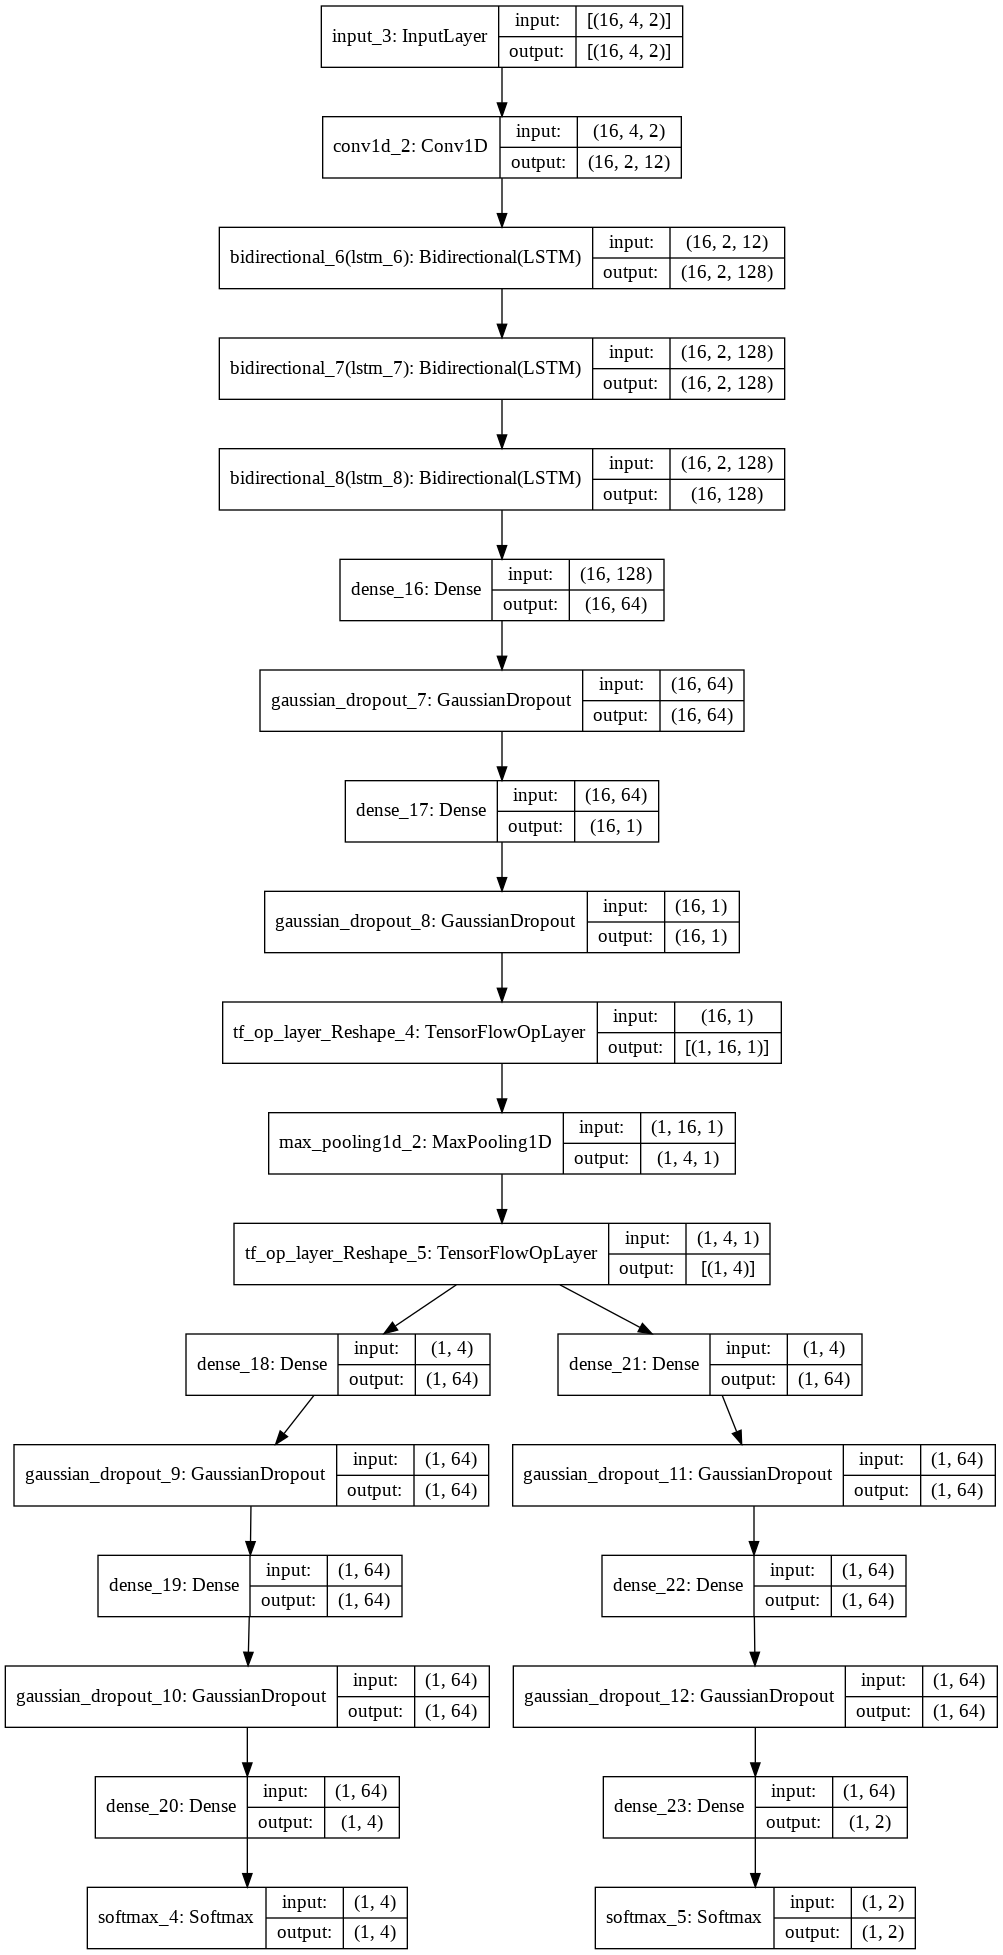

In [4]:
numNN = 3
t = 1
d = 2
t_init = 0
dt = t + d + 1 - t_init 
numDim = 2
numFilter = 12
k = 64
rate = 0.25
# (numNN+1)**d := total number of hypotheses to consider
# dt := length of each track
# numDim := length of each datapoint 
input_size = ((numNN+1)**d, dt, numDim)
ins = keras.Input(shape=input_size[1:], batch_size=input_size[0])
x = layers.Conv1D(numFilter, 3 , activation='relu',input_shape=input_size[1:])(ins)
x = layers.Bidirectional(layers.LSTM(k, return_sequences=True))(x)
x = layers.Bidirectional(layers.LSTM(k, return_sequences=True))(x)
x = layers.Bidirectional(layers.LSTM(k))(x)
x = layers.Dense(k, activation='relu')(x)
x = layers.GaussianDropout(rate)(x)
x = layers.Dense(1, activation='relu')(x)
x = layers.GaussianDropout(rate)(x)
x = tf.reshape(x, [1, x.shape[0], x.shape[1]])
x = layers.MaxPool1D(pool_size=(numNN+1)**(d-1))(x)
x = tf.reshape(x, [x.shape[0], x.shape[1]])
z = layers.Dense(k, input_shape =(numNN+1,1), activation='relu')(x)
z = layers.GaussianDropout(rate)(z)
z = layers.Dense(k, activation='relu')(z)
z = layers.GaussianDropout(rate)(z)
z = layers.Dense(numNN+1, activation='relu')(z)
f1_output = layers.Softmax()(z)

y = layers.Dense(k, input_shape =(numNN+1,1), activation='relu')(x)
y = layers.GaussianDropout(rate)(y)
y = layers.Dense(k, activation='relu')(y)
y = layers.GaussianDropout(rate)(y)
y = layers.Dense(2, activation='relu')(y)
f2_output = layers.Softmax()(y)

ensemble = keras.Model(inputs=ins, outputs=[f1_output, f2_output])

opt = keras.optimizers.Adam(
    learning_rate=0.001,
    beta_1=0.9,
    beta_2=0.999,
    epsilon=1e-07,
    amsgrad=False,
    name="Adam",
)

losses = {
	"assignment": "categorical_crossentropy",
	"existence": "categorical_crossentropy",
}
lossWeights = {"assignment": 1.0, "existence": 1.0}
keras.utils.plot_model(ensemble, show_shapes=True)


In [8]:
ensemble.compile(
    optimizer=opt,
    loss=losses,
    metrics=['accuracy'],
    loss_weights=lossWeights,
    weighted_metrics=None,
    run_eagerly=None,
)

callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)


In [ ]:
history = model.fit(np.arange(100).reshape(5, 20), np.zeros(5),
                    epochs=10, batch_size=1, callbacks=[callback],
                    verbose=0)

In [18]:
# testing loop

# dummy input: particleInfo
particleInfo = np.asarray([[[1, 1],[2, 5], [10, 11]],[[2, 1], [1, 5], [10, 12]],[[12, 10], [2, 2], [2, 5]]])
# get the nearest neighbors
nnMatrices = nnMatrix(3, particleInfo)
# get the total number of frames to process
num_frames = len(particleInfo)
# memorize all the hypothesized tracks
correspondence = []
ground_truth = [[]]

numNN = 3
propFrame = 2
tInit = 0
dim = 2
k = 64

# frame level
for t in range(num_frames-1):
    dt = t + propFrame + 1 -tInit
    # particle level
    for i in range(len(particleInfo[t])):
        # form all the hypotheses
        print(t, particleInfo[t:])
        ptTree = nTree(i, particleInfo[t:t+propFrame], nnMatrices[t:t+propFrame])
        ptTree.printPaths(propFrame)
        tmpPath = np.asarray(ptTree.paths)
        nn_idx = nnMatrices[t][i]['nbrs']

        # piece with existing tracks
        # TBD

        # padding & feed into the network
        padded = defaultdict(list)
        for item in tmpPath:
            tmp = (item[-propFrame][0], item[-propFrame][1])
            item = np.vstack(([[-1, -1]], item, [[-1, -1]]))
            item = tf.constant(item)
            padded[tmp].append(item)

        fold = len(list(padded.values())[0])
        padded[(-1, -1)] = padded[(-1, -1)]*fold
        tests = [tf.stack(li, axis=0) for li in padded.values()]
        for item in tests:
            print(item.shape)
        # f1, f2 = ensemble_model.predict(tests)
        # print(f1)
        # print(nn_idx)
        # tmp = [[i[1], f1[i[0]]] for i in enumerate(nn_idx)]
        # tmp = sorted(tmp, key=lambda pr:pr[0])
        # print(tmp)
        
        
        # existence probability
        # print(f2)
        # existenceProb.append(f2[0])
        assert -1==0
        # result = [it[1] for it in tmp]
        # print("result: ", result)
    #     if assignment == []:
    #         assignment = result
    #     else:
    #         assignment = np.vstack((assignment, result))
    # print("assignment: ", assignment) 
    # tmpCo = dict()
    # valid_index = []
    # valid_assign = []  
    # for i in enumerate(existenceProb):
    #     # track termination -> -1 for termination
    #     if i[1][0] >= i[1][1]:
    #         valid_index.append(i[0])
    #         valid_assign.append(assignment[i[0]])
    #     else:
    #         tmpCo[i[0]] = -1
    # # print("assignment: ", assignment)  
    # row_ind, col_ind = linear_sum_assignment(valid_assign, maximize=True)
    # for i in enumerate(valid_index):
    #     tmpCo[i[1]] = col_ind[i[0]]
    # print(tmpCo)
    # correspondence.append(tmpCo)
        
        
        

        

0 [[[ 1  1]
  [ 2  5]
  [10 11]]

 [[ 2  1]
  [ 1  5]
  [10 12]]

 [[12 10]
  [ 2  2]
  [ 2  5]]]


IndexError: ignored

In [ ]:
padded

[]

In [ ]:
# dummy input: particleInfo
particleInfo = np.asarray([[[1, 1],[2, 5], [10, 11]],[[2, 1], [1, 5], [10, 12]],[[12, 10], [2, 2], [2, 5]]])
# get the nearest neighbors
nnMatrices = nnMatrix(3, particleInfo)
# get the total number of frames to process
num_frames = len(particleInfo)
# memorize all the hypothesized tracks
correspondence = []

t_init = 0
# excluding the last frame particles
for t in range(num_frames-1):
    d = num_frames - t -1
    dt = t + d + 1 -t_init
    assignment = []
    existenceProb = []
    for i in range(len(particleInfo[t])):
        # for the track trees
        # not counting nearest neighbors, all in for now
        # think about recycle the trees for shorter tracks 
        # also think about building the track in reverse order
        ptTree = nTree(i, particleInfo[t:], nnMatrices[t:])
        ptTree.printPaths()
        # print(ptTree.paths)
        tmpPath = np.asarray(ptTree.paths)
        # print(tmpPath[0])
        score_dic = list()
        prev = None
        nn_idx = nnMatrices[t][i]['nbrs']
        
        for hyp in tmpPath:
            # print(hyp[1])
            if((prev == hyp[1]).all() == False):
                if(type(prev) == type(hyp[1])):
                    score_dic.append(tmpDic)
                prev = hyp[1]
                tmpDic = dict()
                tmpDic['track'] = hyp[1]
                tmpDic['score'] = 0
            subNN = subNetwork(hyp)
            # print(tmpDic['track'], subNN)
            tmpDic['score'] = max((tmpDic['score'], subNN[0][0]))
        score_dic.append(tmpDic)
        # print(score_dic)
        sample = [it['score'] for it in score_dic]

        sample = np.asarray(sample).reshape((1, 1,-1))
        f1_out, f2_out = ptNetwork(sample)
        # assignment probability
        tmp = {(i[1], f1_out[0][0][i[0]]) for i in enumerate(nn_idx)}
        tmp = sorted(tmp, key=lambda pr:pr[0])
        # existence probability
        print(f2_out)
        existenceProb.append(f2_out[0][0])
        result = [it[1] for it in tmp]
        # print("result: ", result)
        if assignment == []:
            assignment = result
        else:
            assignment = np.vstack((assignment, result))
    print("assignment: ", assignment) 
    tmpCo = dict()
    valid_index = []
    valid_assign = []  
    for i in enumerate(existenceProb):
        # track termination -> -1 for termination
        if i[1][0] >= i[1][1]:
            valid_index.append(i[0])
            valid_assign.append(assignment[i[0]])
        else:
            tmpCo[i[0]] = -1
    # print("assignment: ", assignment)  
    row_ind, col_ind = linear_sum_assignment(valid_assign, maximize=True)
    for i in enumerate(valid_index):
        tmpCo[i[1]] = col_ind[i[0]]
    print(tmpCo)
    correspondence.append(tmpCo)
    

In [ ]:
row_ind,col_ind
r,c = linear_sum_assignment([assignment[1]], maximize=True)
r,c

(array([0]), array([0]))

In [ ]:
# track formulation from correspondence
correspondence

[{0: -1, 1: 2, 2: -1}, {0: 0, 1: 2, 2: -1}]

In [ ]:
# Jonker-Volgenant shortest augmenting path
# to save time and build the pipeline first, 
# I used a SciPy version of 2D LAP solver implementing a different algorithm instead for now.
# ref: https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.linear_sum_assignment.html
cost = np.asarray([[4,2,5,7],[8,3,10,8],[12, 5,4,5],[6,3,7,14]])
row_ind, col_ind = linear_sum_assignment(cost)

In [ ]:
# translating Pascal code for practice 
# note that in LAP, cost matrix is always a squared matrix
'''
INPUT
n: problem size
c: costs matrix
x: columns assigned to rows
y: rows assigned to columns
u: dual row variables
v: dual column variables
---------------------------
TMPs
d: shortest path lengths
free:unassigned rows
pred: predecessor array for shortest path tree
i, i1: row indices
j, j1, j2: column indices
last: last column in col-array with d[j]<min

'''
def lapjv(n:int, c: list)->int:
    inf = 1000000
    x = np.zeros((n,), dtype=int)
    y = x
    u = x
    v = x
    col = np.asarray(range(n))
    # column reduction
    for j in range(n-1, -1, -1):
        h = c[0][j]
        i1 = 0
        for i in range(1, n):
            if(c[i][j] < h):
                h = c[i][j]
                i1 = i
        v[j] = h
        if x[i1] == 0:
            x[i1] = j
            y[j] = i1
        else:
            x[i] = -abs(x[i])
            y[j] = 0
    
    # reduction transfer
    f = -1
    free = np.zeros((n,), dtype=int)
    for i in range(n):
        if x[i] == 0:
            f+=1
            free[f] = i
        elif x[i] < 0:
            x[i] = -x[i]
        else:
            j1 = x[i]
            min = inf
            for j in range(n):
                if (j!= j1) and (c[i][j]-v[j] < min):
                    min = c[i][j]-v[j]
            v[j1] = v[j1]-min
    
    # augmenting row reduction
    cnt = 0
    while(cnt != 2):
        k=0
        f0 =f
        f = 0
        while k<=f0:
            i = free[k]
            k += 1
            u1 = c[i][0] - v[0]
            j1 = 0
            u2 = inf
            for j in range(1, n):
                h = c[i][j]-v[j]
                if h<u2:
                    if h>= u1:
                        u2 = h
                        j2 = j
                    else:
                        u2 =u1
                        u1 = h
                        j2 = j1
                        j1 = j
            i1 = y[i1]
            if u1<u2:
                v[j1] += -u2 + u1
            elif i1 > 0:
                j1 = j2
                i1 = y[j1]
            if i1>0:
                if u1<u2:
                    k -= 1
                    free[k] = i1
                else:
                    f += 1
                    free[f] = i1
            x[i] = j1
            y[j1] = i
        cnt += 1

    return 0      
    



In [ ]:
# Keras functional model for multi-branch topologies
# src: https://keras.io/guides/functional_api/


0

In [ ]:
cost = np.asarray([[4,2,5,7],[8,3,10,8],[12, 5,4,5],[6,3,7,14]])
from scipy.optimize import linear_sum_assignment
row_ind, col_ind = linear_sum_assignment(cost)
# tmp = lapjv(4, cost)
# np.asarray(range(1, 5))
row_ind, col_ind

(array([0, 1, 2, 3]), array([0, 3, 2, 1]))

# Discard Snippet

In [ ]:
# track tree construction
# ref1: https://scikit-learn.org/stable/modules/neighbors.html
# ref2: on np.stack & concatenate & append performance: 
#       https://stackoverflow.com/questions/33356442/when-should-i-use-hstack-vstack-vs-append-vs-concatenate-vs-column-stack
from sklearn.neighbors import NearestNeighbors
from time import perf_counter

num_neighbors = 4
alg1_s = perf_counter()
for item in enumerate(locations[:-1]):
    idx = item[0]
    frame = item[1]
    nextFrame = locations[idx+1]
    for pt in frame:
        tmp = np.vstack((pt, nextFrame))
        nbrs = NearestNeighbors(n_neighbors=num_neighbors, algorithm='auto').fit(tmp)
        distances, indices = nbrs.kneighbors(tmp)
alg1_e = perf_counter()
print(alg1_e-alg1_s)

68.99911253000005


In [ ]:
# trie ref: https://stackoverflow.com/questions/11015320/how-to-create-a-trie-in-python
# good ref: http://kmike.ru/python-data-structures/
_end = '_end_'
def make_trie(*words):
    root = dict()
    for word in words:
        current_dict = root
        for letter in word:
            print(letter)
            current_dict = current_dict.setdefault(letter, {})
        current_dict[_end] = _end
    return root
ret = make_trie("ace")
ret
# a trie structure for track hypotheses
# class trackTree(object):
#     def __init__(self):
#         node = 
    

In [ ]:
d = 4
k = 64
numFilter = 12
# inShape = ((numNN+1)**d, d+3, 2)
inShape = (d+3, 2)
numNN = 3

input = keras.Input(shape = inShape)
print(input.shape)
x = layers.Conv1D(numFilter, 3 , activation='relu',input_shape=inShape)(input)
# print(x.shape)
x = layers.Bidirectional(layers.LSTM(k, return_sequences=True))(x)
x = layers.Bidirectional(layers.LSTM(k, return_sequences=True))(x)
x = layers.Bidirectional(layers.LSTM(k))(x)
x = layers.Dense(k, activation='relu')(x)
x = layers.Dense(1, activation='relu')(x)
print(x.shape)
x = layers.MaxPool1D(pool_size=(x.shape[0]))(x)
sub = keras.Model(input, x)
keras.utils.plot_model(sub, show_shapes=True)

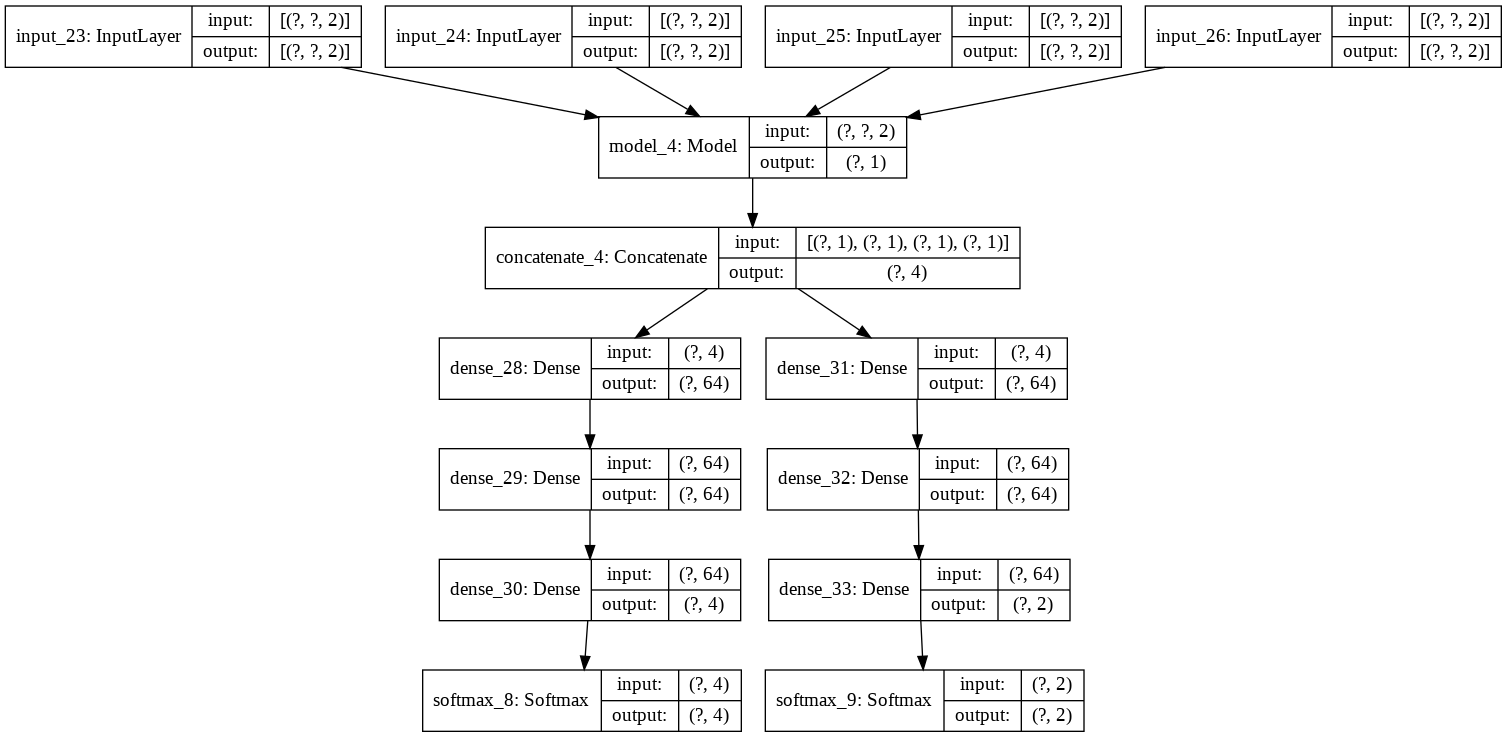

In [ ]:
in1 = keras.Input(shape=inShape)
in2 = keras.Input(shape=inShape)
in3 = keras.Input(shape=inShape)
in4 = keras.Input(shape=inShape)
# in5 = keras.Input(shape=inShape)
ins = [in1, in2, in3, in4]
outs = [sub(it) for it in ins]
outCat = layers.concatenate(outs)

x = layers.Dense(k, input_shape =(None,numNN+1), activation='relu')(outCat)
x = layers.Dense(k, activation='relu')(x)
x = layers.Dense(numNN+1, activation='relu')(x)
f1_output = layers.Softmax()(x)

y = layers.Dense(k, input_shape =(None,numNN+1), activation='relu')(outCat)
y = layers.Dense(k, activation='relu')(y)
y = layers.Dense(2, activation='relu')(y)
f2_output = layers.Softmax()(y)

ensemble_model = keras.Model(inputs=ins, outputs=[f1_output, f2_output])
keras.utils.plot_model(ensemble_model, show_shapes=True)

In [ ]:
# integrated network construction
# ref1: https://www.tensorflow.org/guide/keras/rnn#bidirectional_rnns
# ref2: https://www.tensorflow.org/api_docs/python/tf/pad
# ref3: temporal conv -> https://dida.do/blog/temporal-convolutional-networks-for-sequence-modeling

M = 4

def subNetwork(input,num_filter=12, window_size=3, k=64):
    tensor = tf.constant(input)
    paddings = tf.constant([[1, 1], [0, 0]])
    input_data = tf.pad(tensor, paddings, "CONSTANT", -1)
    shape = input_data.shape  
    in_shape = input_data.numpy().reshape((1, shape[0], shape[1]))
    inputTensor = tf.constant(in_shape)
    # print(inputTensor.shape)
    model = keras.Sequential()
    model.add(layers.Conv1D(num_filter, window_size, activation='relu',input_shape=shape))
    model.add(layers.Bidirectional(layers.LSTM(k, return_sequences=True)))
    model.add(layers.Bidirectional(layers.LSTM(k, return_sequences=True)))
    model.add(layers.Bidirectional(layers.LSTM(k)))
    model.add(layers.Dense(k, activation='relu'))
    model.add(layers.Dense(1, activation='relu'))
    print(model.summary())
    return model(inputTensor).numpy()

def ptNetwork(input, k=64):
    Mplus = input.shape[-1]
    f1_model = keras.Sequential()
    f1_model.add(layers.Dense(k, input_shape =(1,Mplus), activation='relu'))
    f1_model.add(layers.Dense(k, activation='relu'))
    f1_model.add(layers.Dense(Mplus, activation='relu'))
    f1_model.add(layers.Softmax())
    # f1_model.summary()
    # print("f1: ", f1_model(input))

    f2_model = keras.Sequential()
    f2_model.add(layers.Dense(k, input_shape =(1,Mplus), activation='relu'))
    f2_model.add(layers.Dense(k, activation='relu'))
    f2_model.add(layers.Dense(2, activation='relu'))
    f2_model.add(layers.Softmax())
    # print("f2: ", f2_model(input))
    
    return f1_model(input).numpy(), f2_model(input).numpy()
